In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as linalg
import math
import time

# Parameters
d = 0.35 #squid asymmetry
g = 0.08 #transmon cavity coupling
Wq0 = 3.474 #dressed qubit frequency
Wc0 = 7.192 #dressed cavity frequency
lamb_shift  = g**2/(Wc0 - Wq0)
Wc = Wc0 - lamb_shift #bare qubit
Wq = Wq0 + lamb_shift #bare cavity

# hey
gamma_L = 0.1 # chain coupling to the left josephson junction
gamma_R = gamma_L*(1-d)/(1+d) # chain coupling to the right josephson junction

t = 0.1 # chain hopping

E_C = 0.06 # charging energy
E_J_max = (Wq+E_C)**2/8/E_C
# E_J1 = 1
# E_J2 = E_J1
n_g = 0
N = 0 # number of chain fermions

n_0 = 10 #number of CP
steps = 200
flux_0 = 1 #2.067833*10**(-15)
flux_array = np.linspace(-flux_0,flux_0,steps)
num_of_eigen = 4

max_num_photons = 6 #number of photons



# Defining the single spin operators s_x, s_y, s_z:
s_x = 0.5*np.array([[0,1],[1,0]], dtype=complex)
s_y = 0.5*np.array([[0,-1j],[1j,0]], dtype=complex)
s_z = 0.5*np.array([[1,0],[0,-1]], dtype=complex)

s_plus = s_x + 1j*s_y
s_minus = s_x - 1j*s_y

# Defining the creation and annihilation operators for the SCs
exp_phi_plus = np.diag(np.ones(2*n_0, dtype=complex), k=-1) # Creation
exp_phi_minus = np.diag(np.ones(2*n_0, dtype=complex), k=1)# Annihilation

In [4]:

def H_T2(E_C = E_C, n_0 = n_0, n_g = n_g, E_J_max = E_J_max, d = d, flux=0): # The hamiltonian of the transmon alone. n0 is the number of cp passed from one sc to the other
    D = np.zeros(2*n_0+1) #this will be the diagonal
    for i in range(2*n_0+1):
        D[i] = 4*E_C*(-n_0+i-n_g)**2
    H = np.zeros((2*n_0+1,2*n_0+1))
    H = H + np.diag(D) - (E_J_max/2)*np.sqrt(np.cos(np.pi*flux/flux_0)**2 + (d**2)*np.sin(np.pi*flux/flux_0)**2)*(exp_phi_minus + exp_phi_plus)
    return H

def H_C2(N = N, t = t): # the hamiltonian of the chain alone. N is the number of spins in the system (when we count the up and down spins). t is the tunneling constant
    H_C = np.zeros((2**N,2**N), dtype=complex)
    if N < 2 :
        return np.identity(2**N)
    for i in range(0, N-2, 1):
        H_C += np.kron(np.identity(2**(i-1+1), dtype=complex),np.kron(s_plus,np.kron(-s_z, np.kron(s_minus,np.identity(2**(N-(i+2+1)), dtype=complex))))) + \
               np.kron(np.identity(2**(i-1+1), dtype=complex),np.kron(s_minus,np.kron(-s_z, np.kron(s_plus,np.identity(2**(N-(i+2+1)), dtype=complex))))) # I am adding +1 in all the dimensions because the range starts from 0 and the spin index start from 1
    B = np.sum(np.abs(H_C-np.conj(H_C.T)))
    print(B)
    return -t*H_C

def H2(E_C = E_C, n_0 = n_0, n_g = n_g, N = N, t = t, E_J_max = E_J_max, flux = 0): # Transmon and chain together
    H = np.kron(H_T2(E_C,n_0,n_g,E_J_max,flux),np.identity(2**N, dtype=complex)) + \
        np.kron(np.identity((2*n_0+1), dtype=complex),H_C2(N,t))
    return H

def H_int_transmon_chain(N = N, gamma_L = gamma_L, gamma_R = gamma_R, flux = 0):
    exp_plus = np.exp(1j*np.pi*flux/(2*flux_0)) # should be next to phi_L and -phi_R
    exp_minus = np.conj(exp_plus) # should be next to -phi_L and phi_R
    if N < 2:
        return 0
    H_int = gamma_L * (np.kron(exp_plus*exp_phi_plus, np.kron(s_minus,np.kron(s_minus, np.identity(2**(N-2), dtype=complex)))) + np.kron(exp_minus*exp_phi_minus, np.kron(s_plus,np.kron(s_plus, np.identity(2**(N-2), dtype=complex))))) + gamma_R * (np.kron(exp_minus*exp_phi_plus, np.kron(np.identity(2**(N-2), dtype=complex),np.kron(s_minus, s_minus))) + np.kron(exp_plus*exp_phi_minus, np.kron(np.identity(2**(N-2), dtype=complex),np.kron(s_plus, s_plus))))
    return H_int

def H_total2(flux = 0):
    return H2(flux = flux)+H_int_transmon_chain(flux = flux)

tic = time.time()

# harmonic osc creation and annihilation
occupation = np.arange(1,max_num_photons+1, dtype=complex)
a_down = np.diag(np.sqrt(occupation), k=1)
a_up = np.diag(np.sqrt(occupation), k=-1)
occupation_operator = a_up @ a_down

def H_cavity(Wc = Wc):
    H = Wc*(a_up @ a_down)
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_cav:", B)
    return H

def H_int_transmon_cavity(g = g, n_0 = n_0, n_g = n_g): # also added the chain's dimension
    D = np.zeros(2*n_0+1) #this will be the diagonal
    for i in range(2*n_0+1):
        D[i] = (-n_0+i-n_g)
    H = g*np.kron(np.diag(D), np.kron(np.identity(2**N),(a_down+a_up)))
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_int_trans_cav:", B)
    return H

def H_3(flux):
    H = np.kron(H_total2(flux=flux), np.identity(max_num_photons+1)) + np.kron(np.identity((2*n_0+1)), np.kron(np.identity(2**N), H_cavity())) + H_int_transmon_cavity()
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_3:", B)
    return H

tic = time.time()

# test to verify my matrix
# H = H_3(flux[2])
# A = np.sum(np.abs(H - np.conj(H.T)))
# print(A)



eigenvalues_diff2 = np.zeros((steps,(2*n_0+1)*(2**N)*(max_num_photons+1)), dtype=complex) # we have num of rows in the size of steps and columns in the size of (2*n_0+1)*(2**N). each row contains all the eigenvalues for specific flux, so each column is a specific eigenvalue for diff fluxes.
eigenvectors_diff2 = np.zeros((steps,(2*n_0+1)*(2**N)*(max_num_photons+1),(2*n_0+1)*(2**N)*(max_num_photons+1)), dtype=complex)# first dim is steps of flux, 2nd and 3rd dims are for the eigenvectors. so if numpy returns the eigenvectors as a matrix where each column corresponds to eigen-energy, dim 2 is the rows of the matrix and dim 3 is the columns.

for i in range(steps):
    H = H_3(flux = flux_array[i])
    current_eigenvalues, current_eigenvectors = np.linalg.eig(H)
    print(i)
    # sort eigenvalues and rearrange corresponding eigenvectors
    sorted_indices = np.argsort(current_eigenvalues)
    sorted_eigenvalues = current_eigenvalues[sorted_indices]
    sorted_eigenvectors = current_eigenvectors[:, sorted_indices]
    # store results
    eigenvalues_diff2[i,:] = sorted_eigenvalues-sorted_eigenvalues[0] # the difference from the GS
    eigenvectors_diff2[i,:,:] = sorted_eigenvectors

toc = time.time()
print(f"time {toc - tic}s")


hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
0
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
1
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
2
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
3
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
4
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
5
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
6
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
7
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
8
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
9
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
10
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_3: 0.0
11
hermitian of H

Plot of the differences from the GS


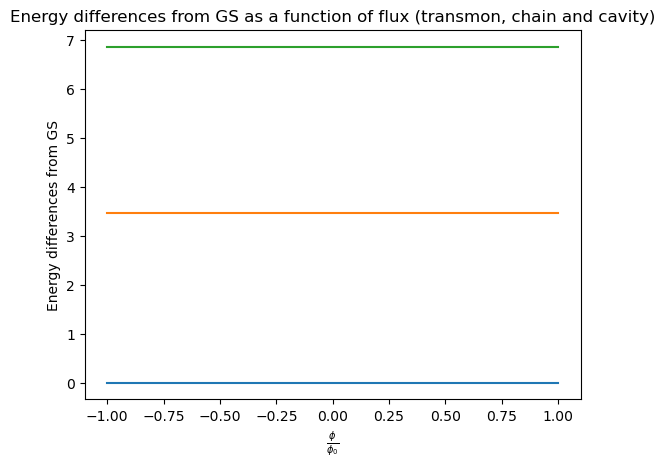

[[[ 5.20790506e-04-0.j -2.44235661e-03+0.j  7.83029681e-03+0.j ...
    3.78342617e-07+0.j  1.44285887e-08-0.j -1.44284495e-08+0.j]
  [ 3.71380346e-05-0.j -1.89097036e-04+0.j  6.53390311e-04+0.j ...
   -1.82468529e-05+0.j -8.41678252e-07+0.j  8.41670421e-07-0.j]
  [ 1.91840194e-06-0.j -1.04881614e-05+0.j  3.87406169e-05+0.j ...
    4.98513394e-04+0.j  2.90273145e-05-0.j -2.90270555e-05+0.j]
  ...
  [ 3.14503961e-09-0.j  1.93590711e-08+0.j  8.01472016e-08+0.j ...
    8.07004658e-02+0.j -9.69499679e-03+0.j -9.69491920e-03+0.j]
  [-1.08907099e-10+0.j -7.05090550e-10+0.j -3.06672751e-09+0.j ...
    3.46204128e-01+0.j -8.60080887e-02+0.j -8.60074546e-02+0.j]
  [ 3.49456014e-12-0.j  2.36873682e-11+0.j  1.07781232e-10+0.j ...
   -4.10465795e-02+0.j -3.52824373e-01+0.j -3.52822048e-01+0.j]]

 [[ 5.20790506e-04-0.j -2.44235661e-03+0.j  7.83029681e-03+0.j ...
    3.78342617e-07+0.j  1.44285887e-08-0.j -1.44284495e-08+0.j]
  [ 3.71380346e-05-0.j -1.89097036e-04+0.j  6.53390311e-04+0.j ...
   -1.82

In [5]:
energies = 3
for i in range(energies):
    plt.plot(flux_array,np.real(eigenvalues_diff2[:,i]))

plt.xlabel(r'$\frac{\phi}{\phi_0}$')
plt.ylabel('Energy differences from GS')
plt.title('Energy differences from GS as a function of flux (transmon, chain and cavity)')

# Save the figure as an image (e.g., PNG)
filename = f'graph_of_energy_diff_from_GS_for_transmon+chain+cavity_{energies}_energies_new.png'
plt.savefig(filename)

# plt.legend()
plt.show()
print(eigenvectors_diff2)

Now I want to plot the difference between any two energies as a function of the flux E_i-E_j when E_i > E_j. also I want to add a color bar and paint the lines in the graph by the transition probability between the levels i and j that is caused from the transmon-cavity coupling meaning the term (a_down+a_up).
I will first create the transition amplitude matrix - M.

In [8]:
amount_of_energies = eigenvalues_diff2.shape[1]
delta_energy = np.zeros((steps,1)) # contains the energy differences, here i will stack the energies
M = np.zeros_like(delta_energy, dtype=complex) # contains the transition probability due to a_down + a_up, here i will stack the probabilities
operator = np.kron(np.identity((2*n_0+1)),np.kron(np.identity(2**N),(a_down+a_up))) # that's the operator I want to get the transition probability for
print(operator.shape) # sanity test

for i in range(amount_of_energies-1, -1, -1): # a loop that iterates from 19 to 0 including
    for j in range(i-1, -1, -1): # a loop that iterates from i-1 to 0 including
        diff = eigenvalues_diff2[:,i] - eigenvalues_diff2[:,j] # should be an array with number of rows as "steps" and one column
        temp = np.hstack((delta_energy, diff.reshape(-1,1))) # here i stack the diff in the delta_energy matrix and reshape the diff column to (-1,1) meaning I want it to be 1 column and the number of rows i leave for numpy to figure out according to the data
        delta_energy = temp
        temp_expectation_vec = np.zeros((steps,1), dtype=complex) # here I want to save the transition probability from j to i for each step because each step have different eigenvectors
        for step in range(steps):
            vec_i = eigenvectors_diff2[step,:,i]
            vec_j = eigenvectors_diff2[step,:,j]
            M_ij = vec_i.conjugate().dot(operator.dot(vec_j))
            temp_expectation_vec[step,0] = M_ij
        temp_M = np.hstack((M, temp_expectation_vec.reshape(-1,1)))
        M = temp_M

print(M.shape)
print(delta_energy.shape)
M = M[:, 1:]
M = np.abs(M)
M = np.log10(M)
delta_energy = delta_energy[:, 1:]
delta_energy = np.abs(delta_energy)


(147, 147)
(200, 10732)
(200, 10732)


Now I will plot the data with colormap

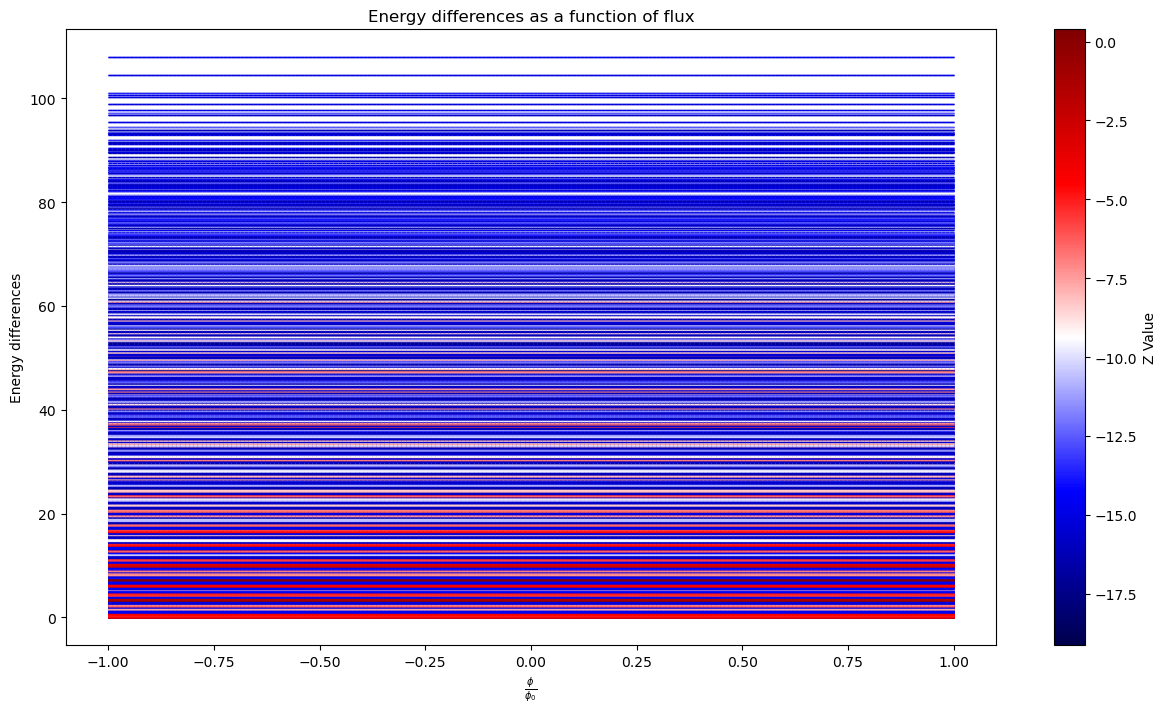

In [9]:
from matplotlib import colors
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection


norm = colors.Normalize(vmin=np.min(M),vmax=np.max(M)) # normalizes the M values to 0-1
cmap = get_cmap('seismic')
fig, ax = plt.subplots(figsize=(15, 8)) # creates a figure and axes objects. figure contains all the elements of a plot - subplots,titles,labels, legends. axes is an individual plotting area within the fig, this is the plot itself. fig contains the axes (subplots)

for i in range(0, delta_energy.shape[1]):
    points = np.array([flux_array, delta_energy[:,i]]).T.reshape(-1, 1, 2) # shaping the x,y points to a (200,1,2) dim so each entry contains a point x,y
    segments = np.concatenate([points[:-1], points[1:]], axis=1) # points[:-1] removes the last point, points[1:] removes the first point. it only slices along the first dim.
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1) # this object contains the line segments and properties needed to create the lines
    lc.set_array(M[:,i]) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection
    ax.add_collection(lc) # add the linecollection to the ax
    if i == 0:
        # Adding colorbar to show the color scale
        cb = plt.colorbar(lc, ax=ax)
        cb.set_label('Z Value')

ax.autoscale() #adjusts the axis limits to fit the data in the subplot
# colorbar = plt.colorbar()
# colorbar.set_label('Custom Value')
plt.xlabel(r'$\frac{\phi}{\phi_0}$')
plt.ylabel('Energy differences')
plt.title('Energy differences as a function of flux')
# plt.ylim(0, 1.2)
# Include parameter values in the legend without lines
# legend_parameter_values = [f'gamma_L: {gamma_L}', f'gamma_R: {gamma_R}', f'tunneling in the chain: {t}']
# handles = [plt.Line2D([], [], linestyle='None', label=value) for value in legend_parameter_values]
# ax.legend(handles=handles)

# Save the figure as an image (e.g., PNG)
filename = f'graph_of_energy_diff_for_transmon+chain+cavity_{amount_of_energies}_new.png'
plt.savefig(filename)

plt.show()